In [1]:
import torch 
from torch import nn
import pandas as pd
import numpy as np
import pybedtools, tqdm, pyBigWig
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import sys
sys.path.insert(0, "src")
import data_managment_utils as data_utils

import matplotlib.pyplot as plt
from torch.distributions import Multinomial

ModuleNotFoundError: No module named 'torch'

In [24]:
sys.path.insert(0, "/homes/users/gravanelli/conda_envs/synth/lib/")
import torch

ImportError: Failed to load PyTorch C extensions:
    It appears that PyTorch has loaded the `torch/_C` folder
    of the PyTorch repository rather than the C extensions which
    are expected in the `torch._C` namespace. This can occur when
    using the `install` workflow. e.g.
        $ python -m pip install --no-build-isolation -v . && python -c "import torch"

    This error can generally be solved using the `develop` workflow
        $ python -m pip install --no-build-isolation -v -e . && python -c "import torch"  # This should succeed
    or by running Python from a different directory.

In [4]:
import numpy

ModuleNotFoundError: No module named 'numpy'

In [2]:
import sys, os
print(sys.executable)
print(sys.path)
print(os.environ.get("PYTHONPATH"))

/opt/conda/bin/python
['/scratch/lab_rmartinez/gravanelli/synthetic_dl', '', '/homes/aplic/installation/lib/python3.6/site-packages', '/scratch/lab_rmartinez/gravanelli/synthetic_dl', '/opt/conda/lib/python311.zip', '/opt/conda/lib/python3.11', '/opt/conda/lib/python3.11/lib-dynload', '/opt/conda/lib/python3.11/site-packages']
/homes/aplic/installation/lib/python3.6/site-packages:


# Test forward pass BPNet 

In [2]:
class BPNetSingleHeadProfile(nn.Module):
    def __init__(self, numFilters: int, widthFilters: int, n_convolutions: int, number_tasks: int):
        
        super().__init__()
        self.numFilters = numFilters
        self.widthFilters = widthFilters
        self.n_convolutions = n_convolutions - 1

        self.initial_conv = nn.Conv1d(4, numFilters, kernel_size=widthFilters, padding=0)
        self.relu = nn.ReLU()
        self.dilated_convs = nn.ModuleList([
            nn.Conv1d(numFilters, numFilters, kernel_size=3, dilation=2**(i+1), padding=0)
            for i in range(self.n_convolutions)
        ])

        self.last_conv = nn.Conv1d(numFilters, number_tasks, kernel_size = widthFilters, padding = 0)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(numFilters, number_tasks)

    def forward(self, x): 
        out = self.relu(self.initial_conv(x))

        # binding core model
        for i, conv in enumerate(self.dilated_convs):
            new_out = self.relu(conv(out))
            crop_of = (out.shape[-1] - new_out.shape[-1]) // 2
            previous_output = out[:, :, crop_of:-crop_of]
            out = previous_output + new_out

        # specific profile heads
        profile_head = self.last_conv(out)
        count_head = self.adaptive_pool(out).squeeze(-1)
        count_head = self.fc(count_head)
        return profile_head, count_head

In [3]:
dataset = data_utils.BPNetDataset("demos/data_dl/train.h5", 2)
dataloader = DataLoader(dataset = dataset, batch_size = 64, shuffle = True)

In [4]:
data = next(iter(dataloader))

In [5]:
data[0].shape, data[1].shape, data[2].shape

(torch.Size([64, 4, 2000]), torch.Size([64, 2, 2000]), torch.Size([64, 2]))

In [7]:
model = BPNetSingleHeadProfile(
    numFilters = 80,
    widthFilters = 7, 
    n_convolutions = 9, 
    number_tasks=2
)

In [8]:
out_profiles = model.forward(data[0])[0]
out_counts = model.forward(data[0])[1]

In [39]:
out_profiles.shape

torch.Size([64, 2, 968])

In [41]:
data_prof_croped = data[1][:, :, 0:968]

torch.Size([64, 2, 968])

In [32]:
class BPNetLosses(nn.Module):
    def __init__(self, num_tasks: int):   
        super().__init__()

        self.num_tasks = num_tasks
        self.profile_loss = 0
        self.count_loss = 0

    def get_profile_loss(self): 
        return self.profile_loss

    def get_count_loss(self): 
        return self.count_loss

    def MSE(self, target_counts, pred_counts):
        
        tot_target_counts = torch.sum(target_counts, 1)
        tot_pred_counts = torch.sum(pred_counts, 1)
        mean_squared_error = torch.mean((tot_target_counts - tot_pred_counts)**2, 0)
        return mean_squared_error

    def multinomial_nll(self, target_profile, pred_logits): 

        batch_size = pred_logits.shape[0]

        flatTask = torch.flatten(target_profile, 1)
        flatCounts = torch.sum(flatTask, 1)
        
        flatLogits = torch.flatten(pred_logits, 1)
        
        batch_multinomial_nll = 0
        for i in range(batch_size): 
            
            dist = Multinomial(
                total_count=int(flatCounts[i].item()),
                logits=flatLogits[i]
            )
            mult_nll = -dist.log_prob(flatTask[i])
            batch_multinomial_nll += mult_nll
            
        return batch_multinomial_nll/batch_size
        
        
    def forward(self, pred_counts, target_counts, pred_prof, target_prof, count_weights):

        counts_raw_loss = self.MSE(
            target_counts = target_counts, 
            pred_counts = pred_counts
        )

        prof_raw_loss = self.multinomial_nll(
            target_profile = target_prof
            pred_logits = pred_prof
        )

        self.profile_loss = counts_raw_loss
        self.count_loss = prof_raw_loss
        
        combined = prof_raw_loss+count_weights*counts_raw_loss

        return combined

# Training tests

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
training = np.loadtxt("demos/models/batch_averaged_training_losses.txt")
validation = np.loadtxt("demos/models/batch_averaged_validation_losses.txt")

(0.0, 1000.0)

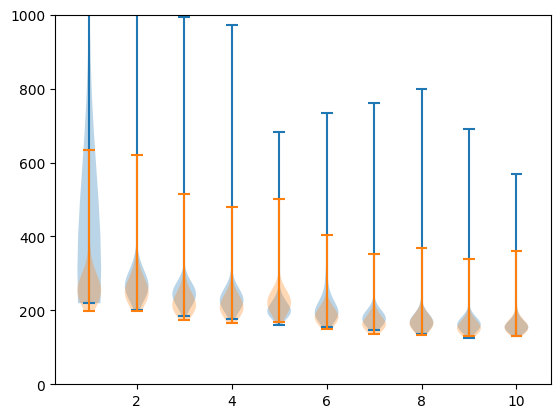

In [35]:
plt.violinplot(training.T); 
plt.violinplot(validation.T);
plt.ylim(0, 1000)

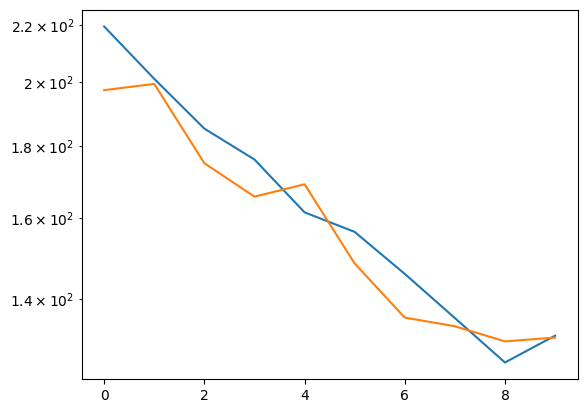

In [30]:
plt.yscale("log")
plt.plot(np.min(training, 1))
plt.plot(np.min(validation, 1))